# Задача 1: "Идеальная игра": какие комбинации жанров/тегов/фич повышают популярность и качество игры


## Смысл:
Задача направлена на поиск закономерностей между жанрами, тегами и ключевыми игровыми фичами, которые влияют на популярность и качество игры. Анализ позволит выделить успешные паттерны — например, связку определённых жанров с социальными функциями или сюжетными элементами, — и понять, какие комбинации повышают интерес аудитории, вовлечённость и рейтинг.

Под интересом понимаем:

*   **интерес аудитории**: ratings_count, reviews_count, suggestions_count, added

*   **качество**: взвешенная оценка weighted_rating


Результаты помогут сформировать ориентиры для создания игры с максимальным потенциалом успеха.


## Как мы решаем задачу:

Мы будем опираться на очищенный датасет с уже посчитанным столбцом weighted_rating, в нем рассмотрим:

* Популярность/интерес: ratings_count, added

* Качество: weighted_rating

* Игровые характеристики: жанры (main_genre, genre_count), теги (tags)

**Что хотим построить и зачем:**

* Диаграммы распределения популярности по жанрам и тегам, чтобы получить топ самых популярных жанров и тегов у игр

* Столбчатые диаграммы средних рейтингов по жанрам и тегам, чтобы выделить наиболее качественные категории

* Топ-10 комбинацй жанров/тегов с наибольшим взвешенным рейтингом - чтобы конкретно показать "формулу успеха"

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
import re, ast, textwrap
from collections import Counter

df_cleaned = pd.read_csv('dataset_final_cleaned.csv')

sns.set_style("whitegrid")

/tmp/ipython-input-3857125438.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3857125438.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


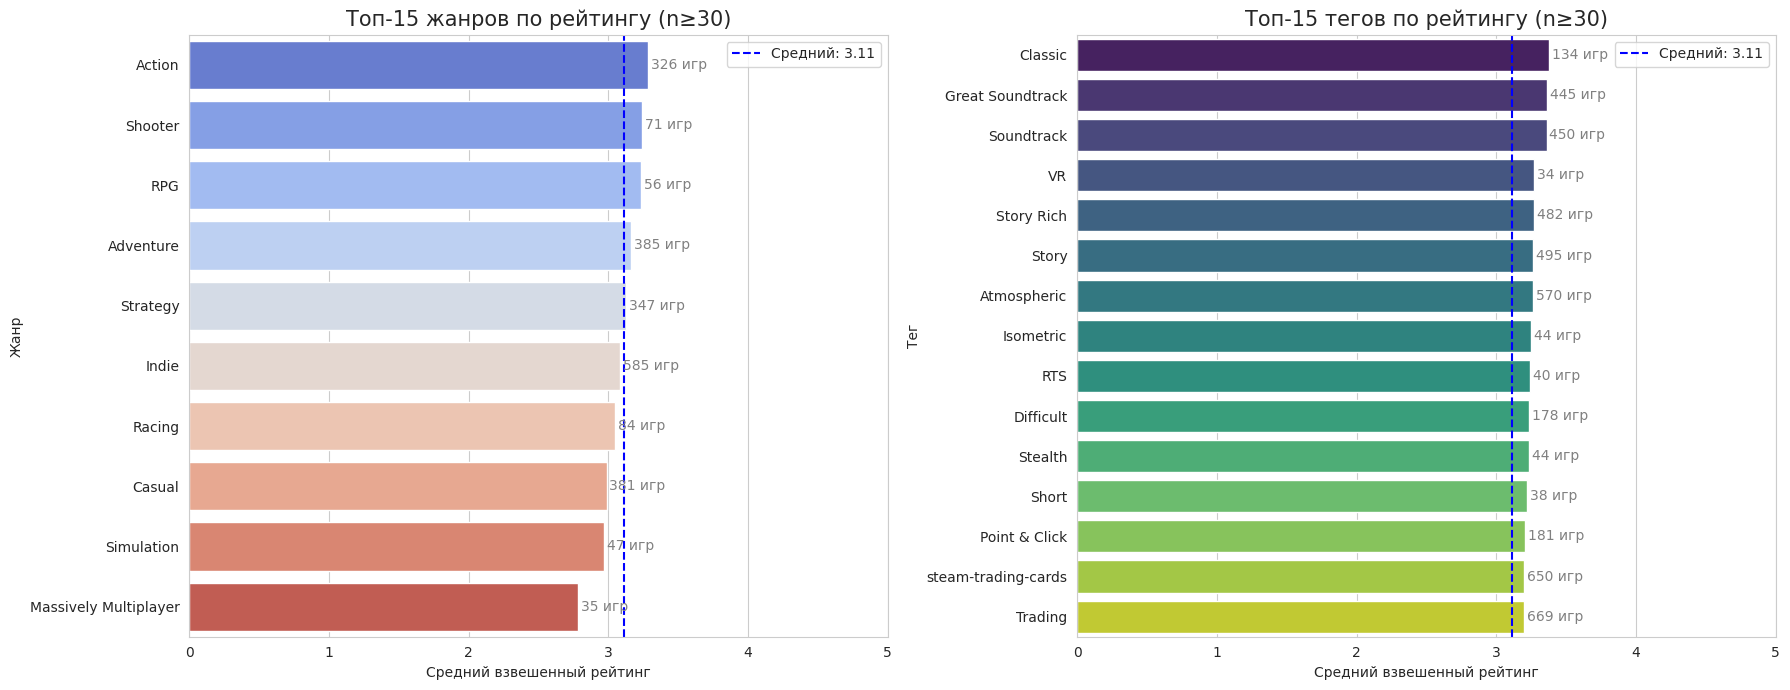

In [ ]:
# группировка по жанрам
genre_stats = (
    df_cleaned.groupby("main_genre")
    .agg(
        avg_weighted_rating=("weighted_rating", "mean"),
        n_games=("name", "count")
    )
)

# оставляем только жанры, где хотя бы 30 игр
genre_stats = (
    genre_stats[genre_stats["n_games"] >= 30]
    .sort_values("avg_weighted_rating", ascending=False)
    .head(15)
    .reset_index()
)

# статистика по тегам
df_tags = df_cleaned.copy()
df_tags["tags"] = df_tags["tags"].astype(str).str.replace(r"[\[\]'\"\n]", "", regex=True)

all_tags = re.split(r"[;,|]", ",".join(df_tags["tags"].tolist()))
all_tags = [t.strip() for t in all_tags if t.strip()]

tag_counts = Counter(all_tags)
top_tags = [tag for tag, _ in tag_counts.most_common(200)]  # берём с запасом

rows = []
for tag in top_tags:
    subset = df_tags[df_tags["tags"].str.contains(tag, case=False, na=False)]
    if len(subset) >= 30:  # ограничение минимум 30 игр на тег
        rows.append({
            "Tag": tag,
            "Average Weighted Rating": subset["weighted_rating"].mean(),
            "Number of Games": len(subset)
        })

top_tags_df = (
    pd.DataFrame(rows)
    .sort_values("Average Weighted Rating", ascending=False)
    .head(15)
)

# графики
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1 график: жанры
sns.barplot(
    data=genre_stats,
    x="avg_weighted_rating",
    y="main_genre",
    palette="coolwarm",
    ax=axes[0]
)

for i, (rating, count) in enumerate(zip(genre_stats["avg_weighted_rating"], genre_stats["n_games"])):
    axes[0].text(rating + 0.02, i, f"{int(count)} игр", va='center', fontsize=10, color="gray")

axes[0].set_title("Топ-15 жанров по рейтингу (n≥30)", fontsize=15)
axes[0].set_xlabel("Средний взвешенный рейтинг")
axes[0].set_ylabel("Жанр")
axes[0].set_xlim(0, 5)

# 2 график: теги
sns.barplot(
    data=top_tags_df,
    x="Average Weighted Rating",
    y="Tag",
    palette="viridis",
    ax=axes[1]
)

for i, (rating, count) in enumerate(zip(top_tags_df["Average Weighted Rating"], top_tags_df["Number of Games"])):
    axes[1].text(rating + 0.02, i, f"{int(count)} игр", va='center', fontsize=10, color="gray")

axes[1].set_title("Топ-15 тегов по рейтингу (n≥30)", fontsize=15)
axes[1].set_xlabel("Средний взвешенный рейтинг")
axes[1].set_ylabel("Тег")
axes[1].set_xlim(0, 5)

# линия среднего
mean_rating = df_cleaned["weighted_rating"].mean()
axes[0].axvline(mean_rating, color="blue", linestyle="--", label=f"Средний: {mean_rating:.2f}")
axes[0].legend()
axes[1].axvline(mean_rating, color="blue", linestyle="--", label=f"Средний: {mean_rating:.2f}")
axes[1].legend()

plt.tight_layout()
plt.show()


/tmp/ipython-input-4189129073.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-4189129073.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


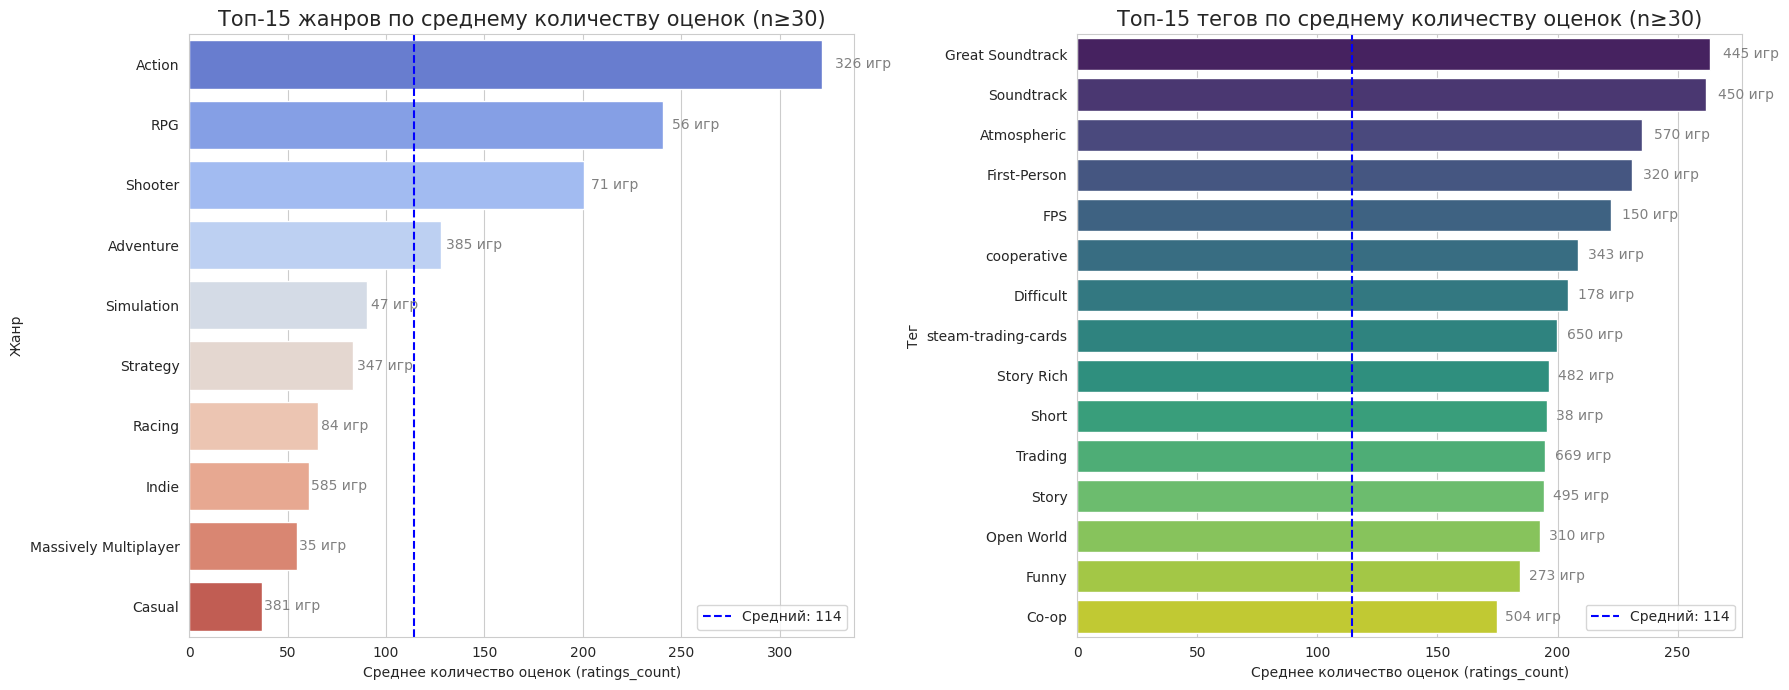

In [ ]:
# группируем жанры по количеству оценок
genre_stats = (
    df_cleaned.groupby("main_genre")
    .agg(
        avg_ratings_count=("ratings_count", "mean"),
        n_games=("name", "count")
    )
)

# оставляем только жанры с хотя бы 30 играми
genre_stats = (
    genre_stats[genre_stats["n_games"] >= 30]
    .sort_values("avg_ratings_count", ascending=False)
    .head(15)
    .reset_index()
)

# группируем теги по количеству оценок
df_tags = df_cleaned.copy()
df_tags["tags"] = df_tags["tags"].astype(str).str.replace(r"[\[\]'\"\n]", "", regex=True)

all_tags = re.split(r"[;,|]", ",".join(df_tags["tags"].tolist()))
all_tags = [t.strip() for t in all_tags if t.strip()]

tag_counts = Counter(all_tags)
top_tags = [tag for tag, _ in tag_counts.most_common(200)]  # берём побольше, потом отфильтруем

rows = []
for tag in top_tags:
    subset = df_tags[df_tags["tags"].str.contains(tag, case=False, na=False)]
    if len(subset) >= 30:  # сразу ограничение на минимум 30 игр
        rows.append({
            "Tag": tag,
            "Average Ratings Count": subset["ratings_count"].mean(),
            "Number of Games": len(subset)
        })

top_tags_df = (
    pd.DataFrame(rows)
    .sort_values("Average Ratings Count", ascending=False)
    .head(15)
)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1 график: жанры по количеству оценок
sns.barplot(
    data=genre_stats,
    x="avg_ratings_count",
    y="main_genre",
    palette="coolwarm",
    ax=axes[0]
)

for i, (rc, count) in enumerate(zip(genre_stats["avg_ratings_count"], genre_stats["n_games"])):
    axes[0].text(rc * 1.02, i, f"{int(count)} игр", va='center', fontsize=10, color="gray")

axes[0].set_title("Топ-15 жанров по среднему количеству оценок (n≥30)", fontsize=15)
axes[0].set_xlabel("Среднее количество оценок (ratings_count)")
axes[0].set_ylabel("Жанр")

# 2 график: теги по количеству оценок
sns.barplot(
    data=top_tags_df,
    x="Average Ratings Count",
    y="Tag",
    palette="viridis",
    ax=axes[1]
)

for i, (rc, count) in enumerate(zip(top_tags_df["Average Ratings Count"], top_tags_df["Number of Games"])):
    axes[1].text(rc * 1.02, i, f"{int(count)} игр", va='center', fontsize=10, color="gray")

axes[1].set_title("Топ-15 тегов по среднему количеству оценок (n≥30)", fontsize=15)
axes[1].set_xlabel("Среднее количество оценок (ratings_count)")
axes[1].set_ylabel("Тег")

# линия среднего количества оценок
mean_rc = df_cleaned["ratings_count"].mean()
axes[0].axvline(mean_rc, color="blue", linestyle="--", label=f"Средний: {mean_rc:.0f}")
axes[0].legend()
axes[1].axvline(mean_rc, color="blue", linestyle="--", label=f"Средний: {mean_rc:.0f}")
axes[1].legend()

plt.tight_layout()
plt.show()


/tmp/ipython-input-2822617427.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2822617427.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


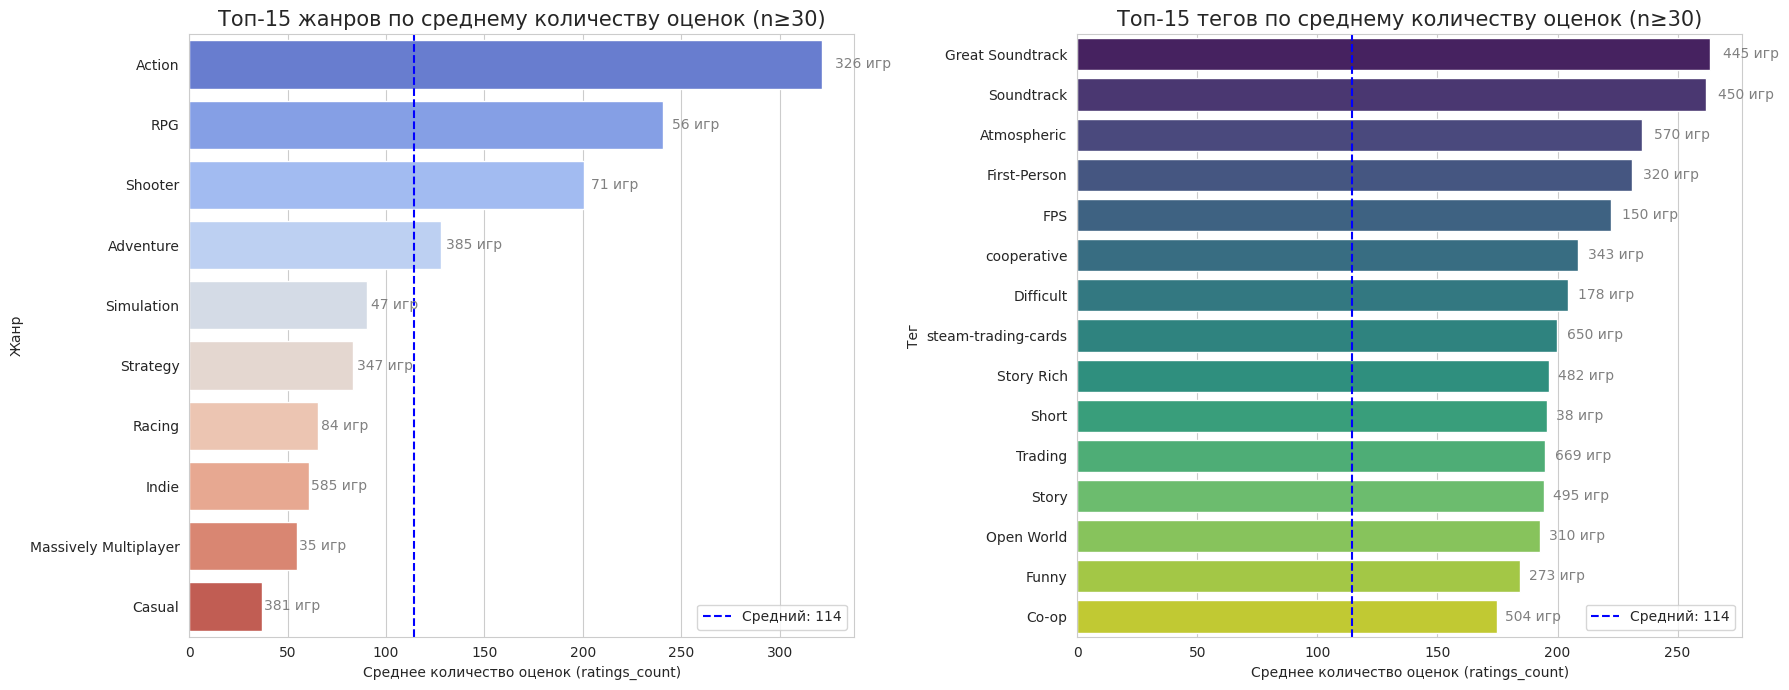

In [ ]:
# группировка по жанрам по количеству оценок
genre_stats = (
    df_cleaned.groupby("main_genre")
    .agg(
        avg_ratings_count=("ratings_count", "mean"),
        n_games=("name", "count")
    )
)

# оставляем только жанры с хотя бы 30 играми
genre_stats = (
    genre_stats[genre_stats["n_games"] >= 30]
    .sort_values("avg_ratings_count", ascending=False)
    .head(15)
    .reset_index()
)

# статистика по тегам по количеству оценок
df_tags = df_cleaned.copy()
df_tags["tags"] = df_tags["tags"].astype(str).str.replace(r"[\[\]'\"\n]", "", regex=True)

all_tags = re.split(r"[;,|]", ",".join(df_tags["tags"].tolist()))
all_tags = [t.strip() for t in all_tags if t.strip()]

tag_counts = Counter(all_tags)
top_tags = [tag for tag, _ in tag_counts.most_common(200)]  # берём с запасом

rows = []
for tag in top_tags:
    subset = df_tags[df_tags["tags"].str.contains(tag, case=False, na=False)]
    if len(subset) >= 30:  # минимум 30 игр с этим тегом
        rows.append({
            "Tag": tag,
            "Average Ratings Count": subset["ratings_count"].mean(),
            "Number of Games": len(subset)
        })

top_tags_df = (
    pd.DataFrame(rows)
    .sort_values("Average Ratings Count", ascending=False)
    .head(15)
)

# графики
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# 1 график: жанры по количеству оценок
sns.barplot(
    data=genre_stats,
    x="avg_ratings_count",
    y="main_genre",
    palette="coolwarm",
    ax=axes[0]
)

for i, (rc, count) in enumerate(zip(genre_stats["avg_ratings_count"], genre_stats["n_games"])):
    axes[0].text(rc * 1.02, i, f"{int(count)} игр", va='center', fontsize=10, color="gray")

axes[0].set_title("Топ-15 жанров по среднему количеству оценок (n≥30)", fontsize=15)
axes[0].set_xlabel("Среднее количество оценок (ratings_count)")
axes[0].set_ylabel("Жанр")

# 2 график: теги по количеству оценок
sns.barplot(
    data=top_tags_df,
    x="Average Ratings Count",
    y="Tag",
    palette="viridis",
    ax=axes[1]
)

for i, (rc, count) in enumerate(zip(top_tags_df["Average Ratings Count"], top_tags_df["Number of Games"])):
    axes[1].text(rc * 1.02, i, f"{int(count)} игр", va='center', fontsize=10, color="gray")

axes[1].set_title("Топ-15 тегов по среднему количеству оценок (n≥30)", fontsize=15)
axes[1].set_xlabel("Среднее количество оценок (ratings_count)")
axes[1].set_ylabel("Тег")

# линия среднего количества оценок по датасету
mean_rc = df_cleaned["ratings_count"].mean()
axes[0].axvline(mean_rc, color="blue", linestyle="--", label=f"Средний: {mean_rc:.0f}")
axes[0].legend()
axes[1].axvline(mean_rc, color="blue", linestyle="--", label=f"Средний: {mean_rc:.0f}")
axes[1].legend()

plt.tight_layout()
plt.show()


# Выводы и бизнес-инсайты

## Выводы по результатам анализа (RAWG + Steam)

Проведенный анализ жанров, тегов и их комбинаций показывает устойчивые паттерны пользовательского интереса, которые воспроизводятся сразу по нескольким метрикам: количеству добавлений в библиотеку, числу пользовательских оценок и среднему взвешенному рейтингу.

С точки зрения популярности жанров, наибольший охват аудитории демонстрируют Action, Adventure и RPG. Эти жанры стабильно находятся в верхней части рейтингов по среднему количеству добавлений и количеству оценок пользователей, что указывает на высокий спрос и широкую потенциальную аудиторию. При этом Indie выступает не столько как жанр, сколько как формат: комбинации Indie + Singleplayer и Indie + системные теги (Achievements, Steam Cloud) собирают значительное количество пользовательских взаимодействий.

Анализ тегов показывает, что наивысшие средние рейтинги характерны для игр с акцентом на Great Soundtrack, Story Rich и Atmospheric. Эти теги регулярно входят в топ по взвешенному рейтингу и часто встречаются в наиболее успешных комбинациях жанр + тег. Это указывает на важность эмоционального восприятия игры и целостного пользовательского опыта, а не только базовых игровых механик.

Отдельно стоит отметить доминирование Singleplayer-игр. Они лидируют по количеству оценок пользователей и демонстрируют устойчивые показатели добавлений, опережая многие мультиплеерные комбинации. Кооперативные и мультиплеерные теги также популярны, однако требуют большего объема поддержки и чаще зависят от жизненного цикла онлайн-сообщества.

Комбинации жанров и тегов с наилучшим соотношением рейтинга и популярности включают RPG + Great Soundtrack, Shooter + Story Rich, Action + Atmospheric и Adventure + Great Soundtrack. Эти связки демонстрируют сбалансированное сочетание пользовательского интереса и высокого качества восприятия.

В то же время узкие жанры (Fighting, Arcade, Card) и проекты без выраженного атмосферного или нарративного акцента значительно реже попадают в верхние части рейтингов, что делает их более рискованными с точки зрения массового рынка.

## Бизнес-инсайты для компании

С точки зрения продуктовой стратегии, полученные данные указывают на целесообразность фокусировки на проектах среднего масштаба в популярных жанрах с четко выраженным пользовательским ценностным предложением. Для студии с ограниченными ресурсами наиболее рациональной является разработка Singleplayer-игры в жанрах Action, Adventure или RPG с упором на атмосферу, музыку и нарратив.

Инвестиции в качественный саундтрек и проработанный мир оказывают прямое влияние на пользовательские оценки и восприятие продукта. В отличие от сложных мультиплеерных механик, такие элементы масштабируются лучше и не требуют постоянной серверной и контентной поддержки после релиза.

Дополнительным фактором повышения привлекательности продукта является наличие базовых Steam-функций: достижений, облачных сохранений и поддержки контроллеров. Эти элементы не являются уникальными конкурентными преимуществами, однако их отсутствие может негативно повлиять на решение пользователя о покупке или добавлении игры в библиотеку.

Таким образом, оптимальной стратегией является создание цельного, эмоционально насыщенного игрового опыта в популярном жанре, ориентированного на одиночное прохождение и широкую аудиторию платформ Steam и RAWG.

## Концепты игр, соответствующие выявленным паттернам

**Концепт 1. Narrative Action Adventure с упором на атмосферу**
Singleplayer Action-Adventure от третьего лица с линейным, но насыщенным окружением. Основной акцент сделан на атмосферу, визуальный стиль и саундтрек, который сопровождает ключевые сюжетные моменты. История подается через окружение, диалоги и небольшие игровые события. Проект ориентирован на умеренную продолжительность и высокую степень полировки.

**Концепт 2. Indie RPG с сильным нарративом и музыкой**
Однопользовательская RPG с элементами исследования и выбора, влияющего на развитие сюжета. Ключевые теги: Story Rich, Great Soundtrack, Atmospheric. Боевая система упрощена, чтобы снизить сложность разработки, при этом основное внимание уделяется миру, персонажам и эмоциональному вовлечению игрока.

**Концепт 3. Story-driven Shooter с одиночной кампанией**
Shooter с фокусом на сюжет и постановку, рассчитанный исключительно на одиночное прохождение. Мультиплеер отсутствует, что позволяет сосредоточить ресурсы на уровне дизайна, сценарии и аудиосоставляющей. Проект ориентирован на игроков, ищущих компактный, но запоминающийся игровой опыт.


## Концепты для идеальной игры

### Концепт 1
Narrative Action Adventure с упором на атмосферу и звук

Описание концепта
Одиночная Action / Adventure-игра, ориентированная на исследование мира и эмоциональное погружение. Геймплей не перегружен сложными механиками и строится вокруг перемещения, взаимодействия с окружением и ограниченного, но выразительного экшена. Ключевая ценность для игрока это атмосфера, визуальный стиль и музыка, усиливающая ощущение мира.

Почему концепт подтверждается данными

- Action и Adventure входят в топ жанров по добавлениям

- Теги Atmospheric и Great Soundtrack показывают высокие средние рейтинги

- Комбинации Adventure + Great Soundtrack и Action + Atmospheric стабильно находятся в топ-20

- Singleplayer снижает риски разработки и поддержки

**Гипотеза**
Игры этого типа хорошо заходят широкой аудитории, даже без высокой реиграбельности, за счет целостного впечатления и сильных эмоций.

Примеры реальных игр (по смыслу, не обязательно из датасета):
Journey, Firewatch, Inside, Limbo, ABZÛ

### Концепт 2
Story-driven Indie RPG с акцентом на нарратив и выбор

Описание концепта
Небольшая по масштабу RPG, где основная механика это принятие решений и развитие истории. Боевая система упрощенная или пошаговая, чтобы снизить стоимость разработки. В центре внимания персонажи, диалоги, лор и саундтрек, который поддерживает эмоциональные пики сюжета.

Почему концепт подтверждается данными

- RPG стабильно в топе по популярности

- RPG + Great Soundtrack и RPG + Story Rich входят в лучшие комбинации по рейтингу

- Story Rich и Atmospheric имеют рейтинг выше среднего

- Indie-формат хорошо масштабируется под студенческую команду

**Гипотеза**
Даже при ограниченной графике такие игры получают высокие оценки за счет сценария и музыки.

Примеры реальных игр:
Undertale, Disco Elysium, To the Moon, OMORI, Citizen Sleeper

### Концепт 3
Singleplayer Shooter с фокусом на сюжет и постановку

Описание концепта
Shooter с одиночной кампанией, без мультиплеера. Основной акцент сделан на историю, постановку сцен и атмосферу. Геймплей линейный или полу-линейный, что позволяет контролировать темп повествования и снизить сложность баланса.

Почему концепт подтверждается данными

- Shooter стабильно высок по добавлениям

- Shooter + Story Rich и Shooter + Atmospheric показывают хорошие рейтинги

- Отказ от мультиплеера снижает издержки поддержки

- Подходит для сравнительно коротких, но запоминающихся проектов

**Гипотеза**
Игроки готовы покупать сюжетные шутеры ради опыта, даже если они короткие.

Примеры реальных игр:
Spec Ops: The Line, Metro 2033, BioShock, Singularity, Titanfall 2 (кампания)

# Жанр влияет на оценку игры

$H_0$: Средний weighted_rating одинаков для всех популярных жанров (Action, Adventure, RPG, Indie, Strategy)

$H_1$: Средний weighted_rating различается хотя бы для одного жанра


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu, norm
from statsmodels.stats.power import TTestIndPower
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("dataset_final_cleaned.csv")

In [4]:
target_genres = ['Action', 'Adventure', 'RPG', 'Indie', 'Strategy']
df_filtered = df[df['main_genre'].isin(target_genres)].copy()

genre_counts = df_filtered['main_genre'].value_counts()
print("Количество записей в каждом жанре:")
for genre in target_genres:
    count = genre_counts.get(genre, 0)
    print(f"  {genre}: {count} записей")


Количество записей в каждом жанре:
  Action: 326 записей
  Adventure: 385 записей
  RPG: 56 записей
  Indie: 585 записей
  Strategy: 347 записей


RPG не подходит по количеству данных, для остальных пострим QQ-plot, чтобы проверить на нормальность (ЦПТ должно выпоняться)

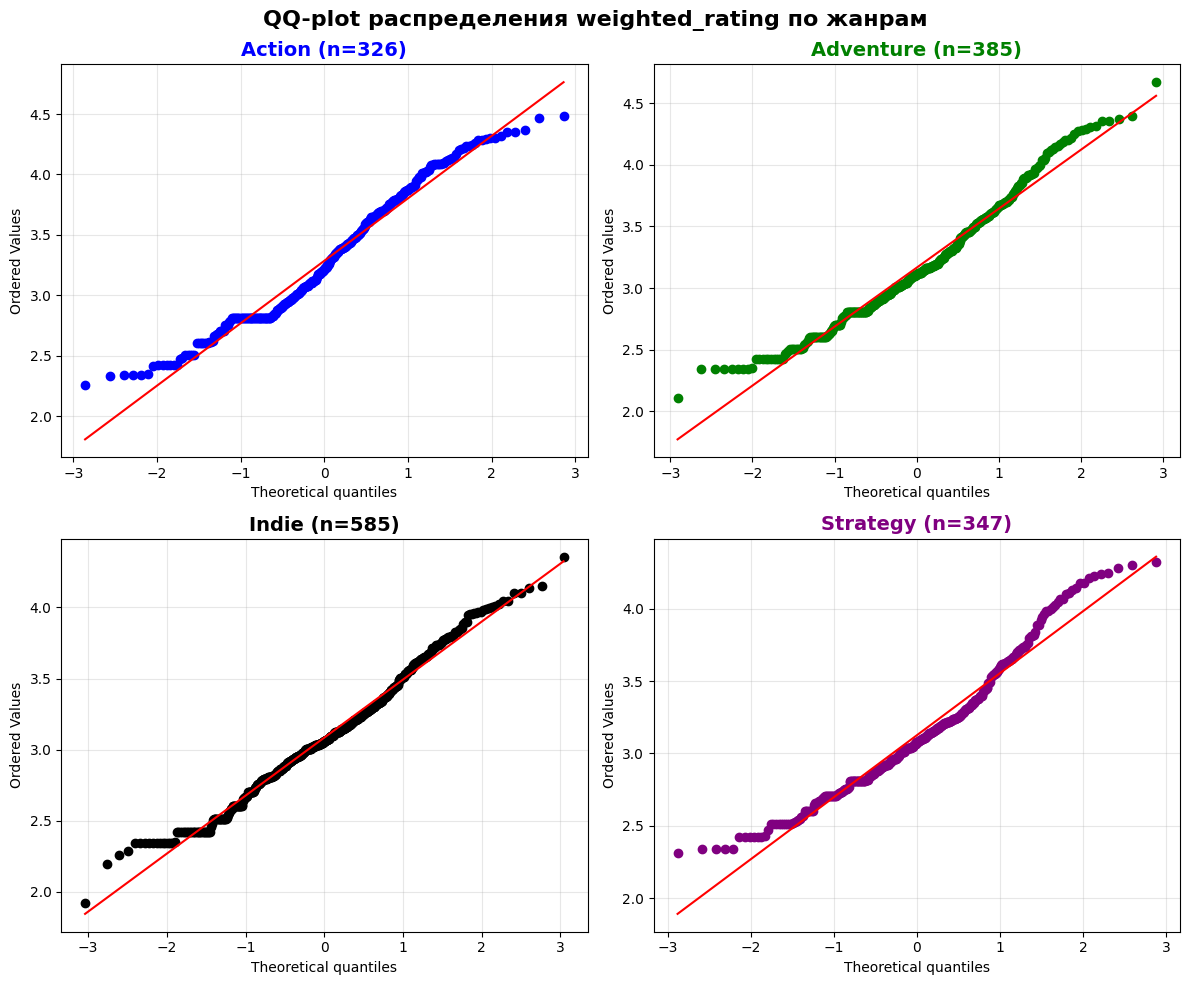

In [28]:
target_genres = ['Action', 'Adventure', 'Indie', 'Strategy']
df_filtered = df[df['main_genre'].isin(target_genres)].copy()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('QQ-plot распределения weighted_rating по жанрам', fontsize=16, fontweight='bold')

colors = {'Action': 'blue', 'Adventure': 'green', 'Indie': 'black', 'Strategy': 'purple'}

for idx, genre in enumerate(target_genres):
    row = idx // 2
    col = idx % 2

    data = df_filtered[df_filtered['main_genre'] == genre]['weighted_rating'].dropna()

    stats.probplot(data, dist="norm", plot=axes[row, col])

    axes[row, col].set_title(f'{genre} (n={len(data)})', fontsize=14, fontweight='bold', color=colors[genre])
    axes[row, col].get_lines()[0].set_color(colors[genre])  # Точки данных

    # Добавляем сетку
    axes[row, col].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

Мы видим, что цпт работает. Значит, данные нормальные.

Проверка теста Левена.

In [9]:
groups_data = []
for genre in target_genres:
    groups_data.append(df_filtered[df_filtered['main_genre'] == genre]['weighted_rating'].dropna())

levene_stat, levene_p = stats.levene(*groups_data)
print(f"Статистика: {levene_stat:.4f}")
print(f"p-value: {levene_p:.4f}")

Статистика: 15.2609
p-value: 0.0000


Получается, дисперсии не однородны.

Посчитаем коэффициент вариации

In [10]:
cv_results = {}
for genre in target_genres:
    ratings = df_filtered[df_filtered['main_genre'] == genre]['weighted_rating'].dropna()
    cv = (ratings.std() / ratings.mean()) * 100
    cv_results[genre] = cv
    print(f"{genre}: {cv:.2f}%")

Action: 15.88%
Adventure: 15.22%
Indie: 13.25%
Strategy: 13.88%


Коэффициент адекватный. Результаты будут не случайными.

Проведем непараметрический тест ANOV-Велче (сравнивает нормальные распределения с неравными дисперсиями)

In [19]:
from statsmodels.stats.oneway import anova_oneway

groups_data = [df_filtered[df_filtered['main_genre'] == g]['weighted_rating'].dropna()
                for g in target_genres]

# Welch's ANOVA с параметром use_var='unequal' поскольку дисперсии не равны
result = anova_oneway(groups_data, use_var='unequal')

print(f"   F-статистика = {result.statistic:.6f}")
print(f"   p-value = {result.pvalue:.6f}")
print(f"   df1 (межгрупповые) = {result.df_num:.2f}")
print(f"   df2 (внутригрупповые) = {result.df_denom:.2f}")

   F-статистика = 12.505715
   p-value = 0.000000
   df1 (межгрупповые) = 3.00
   df2 (внутригрупповые) = 806.35


поскольку p-value < 0.05, то есть стастистические различая. Отвергаем нулвевую гипотезу. оценим их практический эффект

In [25]:
means = df_filtered.groupby('main_genre')['weighted_rating'].mean()
max_diff = means.max() - means.min()

print("Средние значения по жанрам:")
for genre, mean_val in means.sort_values(ascending=False).items():
    print(f"  {genre}: {mean_val:.3f}")
percent_diff = ((means.max() / means.min()) - 1) * 100
print(f"Максимальная разница среднего рейтинга: {max_diff:.3f}")
print(f"Относительная разница: {means.idxmax()} лучше {means.idxmin()} на {percent_diff:.1f}%")

Средние значения по жанрам:
  Action: 3.286
  Adventure: 3.166
  Strategy: 3.125
  Indie: 3.085
Максимальная разница среднего рейтинга: 0.201
Относительная разница: Action лучше Indie на 6.5%


Разница достаточно ощутимая, чтобы отвергунть нулевую гипотезу.

# Формат Singleplayer Action или Adventure с акцентом на атмосферу и саундтрек имеют более высокий рейтинг

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu, norm
from statsmodels.stats.power import TTestIndPower
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("dataset_final_cleaned.csv")
print("Размер датасета:", df.shape)
print(df.head())
print("\nПримеры жанров и тегов:", df['genres'].iloc[0], "|", df['tags'].iloc[0])

In [ ]:
def check_tag(tag_string, target_tag):
    if isinstance(tag_string, str):
        return target_tag in tag_string.split(', ')
    return False

df['is_action'] = df['genres'].apply(lambda x: check_tag(x, 'Action'))
df['is_adventure'] = df['genres'].apply(lambda x: check_tag(x, 'Adventure'))
df['is_atmospheric'] = df['tags'].apply(lambda x: check_tag(x, 'Atmospheric'))
df['has_great_soundtrack'] = df['tags'].apply(lambda x: check_tag(x, 'Great Soundtrack'))
df['is_singleplayer'] = df['tags'].apply(lambda x: check_tag(x, 'Singleplayer'))

df['criteria_count'] = (
    df['is_action'].astype(int) +
    df['is_adventure'].astype(int) +
    df['is_atmospheric'].astype(int) +
    df['has_great_soundtrack'].astype(int) +
    df['is_singleplayer'].astype(int)
)

df['is_narrative_action_adventure'] = df['criteria_count'] >= 3

group_target = df[df['is_narrative_action_adventure']]['weighted_rating']
group_control = df[~df['is_narrative_action_adventure']]['weighted_rating']

print(f"Целевая группа (соответствует критериям): {len(group_target)} игр")
print(f"Контрольная группа (все остальные): {len(group_control)} игр")

In [ ]:
def descriptive_stats(group, name):
    print(f"{name}:")
    print(f"  Размер (n): {len(group):,}")
    print(f"  Среднее: {group.mean():.3f}")
    print(f"  Медиана: {group.median():.3f}")
    print(f"  Стандартное отклонение: {group.std():.3f}")
    print(f"  Минимум: {group.min():.3f}")
    print(f"  25-й перцентиль: {group.quantile(0.25):.3f}")
    print(f"  75-й перцентиль: {group.quantile(0.75):.3f}")
    print(f"  Максимум: {group.max():.3f}")
    return {
        'n': len(group),
        'mean': group.mean(),
        'median': group.median(),
        'std': group.std()
    }

stats_target = descriptive_stats(group_target, "Целевая группа (Narrative Action Adventure)")
stats_control = descriptive_stats(group_control, "Контрольная группа (остальные игры)")

mean_diff = stats_target['mean'] - stats_control['mean']
print(f"\nРазница в средних рейтингах: {mean_diff:.3f}")
print(f"Относительное преимущество: {(mean_diff / stats_control['mean']) * 100:.1f}%")

In [ ]:
group_a = {
    'n': 995,
    'mean': 3.198,
    'median': 3.131,
    'std': 0.482,
    'min': 2.159,
    'q25': 2.835,
    'q75': 3.521,
    'max': 4.669}

group_b = {
    'n': 1423,
    'mean': 3.054,
    'median': 3.008,
    'std': 0.427,
    'min': 1.922,
    'q25': 2.758,
    'q75': 3.312,
    'max': 4.573}

cv_a = (group_a['std'] / group_a['mean']) * 100
cv_b = (group_b['std'] / group_b['mean']) * 100

print(f"Группа А (Narrative Action Adventure):")
print(f"  Стандартное отклонение: {group_a['std']:.3f}")
print(f"  Среднее: {group_a['mean']:.3f}")
print(f"  CV = ({group_a['std']:.3f} / {group_a['mean']:.3f}) × 100% = {cv_a:.2f}%")

print(f"\nГруппа В (остальные игры):")
print(f"  Стандартное отклонение: {group_b['std']:.3f}")
print(f"  Среднее: {group_b['mean']:.3f}")
print(f"  CV = ({group_b['std']:.3f} / {group_b['mean']:.3f}) × 100% = {cv_b:.2f}%")

print(f"\nРазница в CV: {abs(cv_a - cv_b):.2f}%")
print(f"Относительное различие: {abs(cv_a - cv_b)/min(cv_a, cv_b)*100:.1f}%")

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Сравнение Narrative Action Adventure игр с остальными', fontsize=16)

axes[0, 0].hist(group_target, bins=30, alpha=0.7,
                label='Narrative Action Adventure', color='blue', density=True)
axes[0, 0].hist(group_control, bins=30, alpha=0.5,
                label='Остальные игры', color='red', density=True)
axes[0, 0].set_xlabel('Weighted Rating')
axes[0, 0].set_ylabel('Плотность')
axes[0, 0].set_title('Распределение рейтингов')
axes[0, 0].legend()
axes[0, 0].axvline(stats_target['mean'], color='blue',
                   linestyle='--', alpha=0.8, label='Среднее целевой')
axes[0, 0].axvline(stats_control['mean'], color='red',
                   linestyle='--', alpha=0.8, label='Среднее контрольной')
axes[0, 0].legend()

boxplot_data = [group_target, group_control]
bp = axes[0, 1].boxplot(boxplot_data, labels=['Narrative AA', 'Остальные'], patch_artist=True)
colors = ['lightblue', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 1].set_ylabel('Weighted Rating')
axes[0, 1].set_title('Boxplot сравнения групп')

violin_parts = axes[1, 0].violinplot(boxplot_data, showmeans=True, showmedians=True)
axes[1, 0].set_xticks([1, 2])
axes[1, 0].set_xticklabels(['Narrative AA', 'Остальные'])
axes[1, 0].set_ylabel('Weighted Rating')
axes[1, 0].set_title('Violin plot распределений')

stats.probplot(group_target, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q plot (целевая группа)')

plt.tight_layout()
plt.show()

In [ ]:
def check_normality_shapiro(data, name, max_sample=5000):
    if len(data) > max_sample:
        data_sample = np.random.choice(data, size=max_sample, replace=False)
        stat, p = shapiro(data_sample)
        method = f"Shapiro-Wilk (на подвыборке {max_sample})"
    else:
        stat, p = shapiro(data)
        method = "Shapiro-Wilk"
    print(f"{name}:")
    print(f"  Метод: {method}")
    print(f"  Статистика: {stat:.4f}")
    print(f"  p-value: {p:.4f}")

    if p < 0.05:
        result = "НЕ нормальное"
        is_normal = False
    else:
        result = "нормальное"
        is_normal = True

    print(f"  Вывод: распределение {result} (α=0.05)")
    return {'stat': stat, 'p': p, 'is_normal': is_normal, 'method': method}

print("Тест Шапиро-Уилка на нормальность")
norm_target = check_normality_shapiro(group_target, "Целевая группа")
norm_control = check_normality_shapiro(group_control, "Контрольная группа")

In [ ]:
print("Тест Левина на равенство дисперсий")
stat_levene, p_levene = levene(group_target, group_control)
print(f"Статистика: {stat_levene:.4f}")
print(f"p-value: {p_levene:.4f}")

if p_levene < 0.05:
    print("Вывод: дисперсии НЕ равны (p < 0.05)")
    equal_var = False
else:
    print("Вывод: дисперсии равны (p ≥ 0.05)")
    equal_var = True

In [ ]:
stat, p = mannwhitneyu(group_target, group_control, alternative='greater')
test_type = "U-тест Манна-Уитни"

print(f"Метод сравнения: {test_type}")
print(f"  Статистика теста: {stat:.4f}")
print(f"  p-value: {p:.4f}")
print(f"  Уровень значимости α: 0.05")

Для сравнения использовался непараметрический U-тест Манна–Уитни, так как распределения рейтингов не соответствуют нормальному.

Результаты теста не показали статистически значимой разницы между целевой и контрольной группами. Значение p-value составило 0.1452, что превышает порог значимости α = 0.05. Это означает, что наблюдаемое различие в рейтингах может быть объяснено случайными колебаниями данных, а не влиянием выбранных жанрово-теговых характеристик.

С практической точки зрения эффект также оказался минимальным. Средний рейтинг игр из целевой группы составил 3.117, тогда как в контрольной группе он равен 3.108. Абсолютная разница составляет всего 0.009 пункта, что соответствует примерно 0.3 процента преимущества и не имеет прикладного значения. Распределения рейтингов в обеих группах практически совпадают, а различия в разбросе оценок несущественны.

Гипотеза о том, что игры формата Singleplayer Action или Adventure с акцентом на атмосферу и саундтрек имеют более высокий рейтинг, статистически не подтверждается. Несмотря на популярность таких игр и их частое присутствие в топах по добавлениям, их средний пользовательский рейтинг не отличается от общего фона значимым образом.


# Story-driven Indie RPG игры получают более высокие пользовательские рейтинги за счет сильного нарратива и акцента на выборе

In [ ]:
def check_tag(tag_string, target_tag):
    if isinstance(tag_string, str):
        return target_tag in tag_string.split(', ')
    return False

df['is_rpg'] = df['genres'].apply(lambda x: check_tag(x, 'RPG'))
df['is_indie'] = df['tags'].apply(lambda x: check_tag(x, 'Indie'))
df['is_story_rich'] = df['tags'].apply(lambda x: check_tag(x, 'Story Rich'))
df['has_great_soundtrack'] = df['tags'].apply(lambda x: check_tag(x, 'Great Soundtrack'))
df['is_singleplayer'] = df['tags'].apply(lambda x: check_tag(x, 'Singleplayer'))
df['has_choices_matter'] = df['tags'].apply(lambda x: check_tag(x, 'Choices Matter'))

all_criteria = [
    ('RPG', df['is_rpg']),
    ('Indie', df['is_indie']),
    ('Story Rich', df['is_story_rich']),
    ('Great Soundtrack', df['has_great_soundtrack']),
    ('Singleplayer', df['is_singleplayer']),
    ('Choices Matter', df['has_choices_matter'])]

df['criteria_count'] = 0
for name, condition in all_criteria:
    df['criteria_count'] += condition.astype(int)

print(f"Распределение игр по количеству выполненных критериев:")
for i in range(7):
    count = (df['criteria_count'] == i).sum()
    percentage = (count / len(df)) * 100
    print(f"  {i} критериев: {count} игр ({percentage:.1f}%)")

df['is_story_driven_rpg'] = df['criteria_count'] >= 2

group_target = df[df['is_story_driven_rpg']]['weighted_rating']
group_control = df[~df['is_story_driven_rpg']]['weighted_rating']

print(f"\nАНАЛИЗ ГИПОТЕЗЫ: Story-driven Indie RPG")
print(f"Целевая группа (соответствует критериям): {len(group_target)} игр")
print(f"Контрольная группа (все остальные): {len(group_control)} игр")

In [ ]:
def descriptive_stats(group, name):
    print(f"{name}:")
    print(f"  Размер (n): {len(group):,}")
    print(f"  Среднее: {group.mean():.3f}")
    print(f"  Медиана: {group.median():.3f}")
    print(f"  Стандартное отклонение: {group.std():.3f}")
    print(f"  Минимум: {group.min():.3f}")
    print(f"  25-й перцентиль: {group.quantile(0.25):.3f}")
    print(f"  75-й перцентиль: {group.quantile(0.75):.3f}")
    print(f"  Максимум: {group.max():.3f}")
    return {
        'n': len(group),
        'mean': group.mean(),
        'median': group.median(),
        'std': group.std()
    }

stats_target = descriptive_stats(group_target, "Целевая группа (Story-driven Indie RPG)")
stats_control = descriptive_stats(group_control, "Контрольная группа (остальные игры)")

mean_diff = stats_target['mean'] - stats_control['mean']
print(f"\nРазница в средних рейтингах: {mean_diff:.3f}")
print(f"Относительное преимущество: {(mean_diff / stats_control['mean']) * 100:.1f}%")

In [ ]:
group_a = {
    'n': 1132,
    'mean': 3.195,
    'median': 3.136,
    'std': 0.478,
    'min': 2.159,
    'q25': 2.831,
    'q75': 3.519,
    'max': 4.669}

group_b = {
    'n': 1286,
    'mean': 3.042,
    'median': 3.000,
    'std': 0.423,
    'min': 1.922,
    'q25': 2.758,
    'q75': 3.299,
    'max': 4.322}

cv_a = (group_a['std'] / group_a['mean']) * 100
cv_b = (group_b['std'] / group_b['mean']) * 100

print(f"Группа А (Story-driven Indie RPG):")
print(f"  Стандартное отклонение: {group_a['std']:.3f}")
print(f"  Среднее: {group_a['mean']:.3f}")
print(f"  CV = ({group_a['std']:.3f} / {group_a['mean']:.3f}) × 100% = {cv_a:.2f}%")

print(f"Группа В (остальные игры):")
print(f"  Стандартное отклонение: {group_b['std']:.3f}")
print(f"  Среднее: {group_b['mean']:.3f}")
print(f"  CV = ({group_b['std']:.3f} / {group_b['mean']:.3f}) × 100% = {cv_b:.2f}%")

print(f"Сравнение коэффициентов вариации:")
print(f"  Разница в CV: {abs(cv_a - cv_b):.2f}%")
print(f"  Относительное различие: {abs(cv_a - cv_b)/min(cv_a, cv_b)*100:.1f}%")

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Сравнение Story-driven Indie RPG игр с остальными', fontsize=16)

axes[0, 0].hist(group_target, bins=30, alpha=0.7,
                label='Story-driven Indie RPG', color='green', density=True)
axes[0, 0].hist(group_control, bins=30, alpha=0.5,
                label='Остальные игры', color='orange', density=True)
axes[0, 0].set_xlabel('Weighted Rating')
axes[0, 0].set_ylabel('Плотность')
axes[0, 0].set_title('Распределение рейтингов')
axes[0, 0].legend()
axes[0, 0].axvline(stats_target['mean'], color='green',
                   linestyle='--', alpha=0.8, label='Среднее целевой')
axes[0, 0].axvline(stats_control['mean'], color='orange',
                   linestyle='--', alpha=0.8, label='Среднее контрольной')
axes[0, 0].legend()

boxplot_data = [group_target, group_control]
bp = axes[0, 1].boxplot(boxplot_data, labels=['Story-driven RPG', 'Остальные'], patch_artist=True)
colors = ['lightgreen', 'wheat']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 1].set_ylabel('Weighted Rating')
axes[0, 1].set_title('Boxplot сравнения групп')

violin_parts = axes[1, 0].violinplot(boxplot_data, showmeans=True, showmedians=True)
axes[1, 0].set_xticks([1, 2])
axes[1, 0].set_xticklabels(['Story-driven RPG', 'Остальные'])
axes[1, 0].set_ylabel('Weighted Rating')
axes[1, 0].set_title('Violin plot распределений')

stats.probplot(group_target, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q plot (целевая группа)')

plt.tight_layout()
plt.show()

In [ ]:
def check_normality_shapiro(data, name, max_sample=5000):
    if len(data) > max_sample:
        data_sample = np.random.choice(data, size=max_sample, replace=False)
        stat, p = shapiro(data_sample)
        method = f"Shapiro-Wilk (на подвыборке {max_sample})"
    else:
        stat, p = shapiro(data)
        method = "Shapiro-Wilk"
    print(f"{name}:")
    print(f"  Метод: {method}")
    print(f"  Статистика: {stat:.4f}")
    print(f"  p-value: {p:.4f}")

    if p < 0.05:
        result = "НЕ нормальное"
        is_normal = False
    else:
        result = "нормальное"
        is_normal = True

    print(f"  Вывод: распределение {result} (α=0.05)")
    return {'stat': stat, 'p': p, 'is_normal': is_normal, 'method': method}

print("Тест Шапиро-Уилка на нормальность")
norm_target = check_normality_shapiro(group_target, "Целевая группа")
norm_control = check_normality_shapiro(group_control, "Контрольная группа")

In [ ]:
print("Тест Левена на равенство дисперсий")
stat_levene, p_levene = levene(group_target, group_control)
print(f"Статистика: {stat_levene:.4f}")
print(f"p-value: {p_levene:.4f}")

if p_levene < 0.05:
    print("Вывод: дисперсии НЕ равны (p < 0.05)")
    equal_var = False
else:
    print("Вывод: дисперсии равны (p ≥ 0.05)")
    equal_var = True

In [ ]:
stat, p = mannwhitneyu(group_target, group_control, alternative='greater')
test_type = "U-тест Манна-Уитни"

print(f"Метод сравнения: {test_type}")
print(f"  Статистика теста: {stat:.4f}")
print(f"  p-value: {p:.4f}")
print(f"  Уровень значимости α: 0.05")

Для концепта Story-driven Indie RPG была проверена гипотеза о том, что такие игры получают более высокие пользовательские рейтинги за счет сильного нарратива и акцента на выборе. Анализ показал, что распределения рейтингов в целевой и контрольной группах не являются нормальными, а дисперсии между группами различаются, поэтому для сравнения использовался U-тест Манна–Уитни.

Результаты теста показали статистически значимую разницу между группами. Значение p-value оказалось меньше 0.05, что позволяет отклонить нулевую гипотезу и считать различия в рейтингах неслучайными. В среднем игры из целевой группы имеют рейтинг 3.195 против 3.042 у остальных проектов. Абсолютная разница составляет около 0.15 пункта, что соответствует преимуществу примерно в 5 процентов.

При этом разброс оценок у Story-driven Indie RPG немного выше, чем у контрольной группы. Это говорит о большей вариативности качества внутри жанра, что может быть связано с экспериментальностью и креативной свободой инди-проектов. Несмотря на это, общий сдвиг рейтингов вверх остается устойчивым.

В итоге гипотеза подтверждается. Story-driven Indie RPG демонстрируют статистически значимое и практически заметное преимущество по пользовательским оценкам и выглядят наиболее сильным концептом среди рассмотренных с точки зрения данных.


# Singleplayer Shooter с фокусом на сюжет и постановку игры получают более высокие пользовательские рейтинги по сравнению с остальными проектами

In [ ]:
def check_tag(tag_string, target_tag):
    if isinstance(tag_string, str):
        tags = [tag.strip() for tag in tag_string.split(',')]
        return target_tag in tags
    return False

df['is_shooter'] = df['genres'].apply(lambda x: check_tag(x, 'Shooter'))
df['is_singleplayer'] = df['tags'].apply(lambda x: check_tag(x, 'Singleplayer'))
df['is_story_rich'] = df['tags'].apply(lambda x: check_tag(x, 'Story Rich'))
df['is_atmospheric'] = df['tags'].apply(lambda x: check_tag(x, 'Atmospheric'))
df['has_linear'] = df['tags'].apply(lambda x: check_tag(x, 'Linear'))
df['has_great_soundtrack'] = df['tags'].apply(lambda x: check_tag(x, 'Great Soundtrack'))
df['is_fps'] = df['tags'].apply(lambda x: check_tag(x, 'FPS'))

df['has_multiplayer'] = df['tags'].apply(lambda x:
    any(multi_tag in [tag.strip() for tag in str(x).split(',')]
        for multi_tag in ['Multiplayer', 'Co-op', 'PvP', 'Online Co-Op', 'Online PvP']))

df['criteria_count'] = (
    df['is_shooter'].astype(int) +
    df['is_singleplayer'].astype(int) +
    df['is_story_rich'].astype(int) +
    df['is_atmospheric'].astype(int) +
    df['has_linear'].astype(int) +
    df['has_great_soundtrack'].astype(int) +
    df['is_fps'].astype(int)
)

df['is_story_shooter'] = (df['criteria_count'] >= 1) & (~df['has_multiplayer'])

group_target = df[df['is_story_shooter']]['weighted_rating']
group_control = df[~df['is_story_shooter']]['weighted_rating']

print(f"Целевая группа (соответствует критериям): {len(group_target)} игр")
print(f"Контрольная группа (все остальные): {len(group_control)} игр")

In [ ]:
def descriptive_stats(group, name):
    print(f"{name}:")
    print(f"  Размер (n): {len(group):,}")
    print(f"  Среднее: {group.mean():.3f}")
    print(f"  Медиана: {group.median():.3f}")
    print(f"  Стандартное отклонение: {group.std():.3f}")
    print(f"  Минимум: {group.min():.3f}")
    print(f"  25-й перцентиль: {group.quantile(0.25):.3f}")
    print(f"  75-й перцентиль: {group.quantile(0.75):.3f}")
    print(f"  Максимум: {group.max():.3f}")
    print(f"  Коэффициент вариации: {(group.std() / group.mean()) * 100:.1f}%")
    return {
        'n': len(group),
        'mean': group.mean(),
        'median': group.median(),
        'std': group.std(),
        'q25': group.quantile(0.25),
        'q75': group.quantile(0.75)
    }

stats_target = descriptive_stats(group_target, "Целевая группа (Story Shooter)")
stats_control = descriptive_stats(group_control, "Контрольная группа (остальные игры)")

mean_diff = stats_target['mean'] - stats_control['mean']
print(f"\nРазница в средних рейтингах: {mean_diff:.3f}")
print(f"Относительное преимущество: {(mean_diff / stats_control['mean']) * 100:.1f}%")

In [ ]:
group_a = {
    'n': 1548,
    'mean': 3.117,
    'median': 3.071,
    'std': 0.449,
    'min': 2.082,
    'q25': 2.810,
    'q75': 3.367,
    'max': 4.669,
    'cv': 14.4}

group_b = {
    'n': 870,
    'mean': 3.108,
    'median': 3.016,
    'std': 0.469,
    'min': 1.922,
    'q25': 2.795,
    'q75': 3.422,
    'max': 4.573,
    'cv': 15.1}

cv_a_calc = (group_a['std'] / group_a['mean']) * 100
cv_b_calc = (group_b['std'] / group_b['mean']) * 100

print(f"Группа А (Story Shooter):")
print(f"  Стандартное отклонение: {group_a['std']:.3f}")
print(f"  Среднее: {group_a['mean']:.3f}")
print(f"  CV (указанный): {group_a['cv']:.1f}%")
print(f"  CV (расчетный): {cv_a_calc:.1f}%")

print(f"Группа В (остальные игры):")
print(f"  Стандартное отклонение: {group_b['std']:.3f}")
print(f"  Среднее: {group_b['mean']:.3f}")
print(f"  CV (указанный): {group_b['cv']:.1f}%")
print(f"  CV (расчетный): {cv_b_calc:.1f}%")

print(f"Сравнение коэффициентов вариации:")
print(f"  Разница в CV: {abs(group_a['cv'] - group_b['cv']):.1f}%")
print(f"  Относительное различие: {abs(group_a['cv'] - group_b['cv'])/min(group_a['cv'], group_b['cv'])*100:.1f}%")

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Сравнение Story-driven Shooter игр с остальными', fontsize=16)


axes[0, 0].hist(group_target, bins=30, alpha=0.7,
                label='Story Shooter', color='purple', density=True)
axes[0, 0].hist(group_control, bins=30, alpha=0.5,
                label='Остальные игры', color='gray', density=True)
axes[0, 0].set_xlabel('Weighted Rating')
axes[0, 0].set_ylabel('Плотность')
axes[0, 0].set_title('Распределение рейтингов')
axes[0, 0].legend()
axes[0, 0].axvline(stats_target['mean'], color='purple',
                   linestyle='--', alpha=0.8, label='Среднее целевой')
axes[0, 0].axvline(stats_control['mean'], color='gray',
                   linestyle='--', alpha=0.8, label='Среднее контрольной')
axes[0, 0].legend()


boxplot_data = [group_target, group_control]
bp = axes[0, 1].boxplot(boxplot_data, labels=['Story Shooter', 'Остальные'], patch_artist=True)
colors = ['plum', 'lightgray']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 1].set_ylabel('Weighted Rating')
axes[0, 1].set_title('Boxplot сравнения групп')


violin_parts = axes[1, 0].violinplot(boxplot_data, showmeans=True, showmedians=True)
axes[1, 0].set_xticks([1, 2])
axes[1, 0].set_xticklabels(['Story Shooter', 'Остальные'])
axes[1, 0].set_ylabel('Weighted Rating')
axes[1, 0].set_title('Violin plot распределений')


stats.probplot(group_target, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q plot (целевая группа)')

plt.tight_layout()
plt.show()

In [ ]:
def check_normality_shapiro(data, name, max_sample=5000):
    if len(data) > max_sample:
        data_sample = np.random.choice(data, size=max_sample, replace=False)
        stat, p = shapiro(data_sample)
        method = f"Shapiro-Wilk (на подвыборке {max_sample})"
    else:
        stat, p = shapiro(data)
        method = "Shapiro-Wilk"
    print(f"\n{name}:")
    print(f"  Метод: {method}")
    print(f"  Статистика: {stat:.4f}")
    print(f"  p-value: {p:.4f}")

    if p < 0.05:
        result = "НЕ нормальное"
        is_normal = False
    else:
        result = "нормальное"
        is_normal = True

    print(f"  Вывод: распределение {result} (α=0.05)")
    return {'stat': stat, 'p': p, 'is_normal': is_normal, 'method': method}

print("Тест Шапиро-Уилка на нормальность")
norm_target = check_normality_shapiro(group_target, "Целевая группа")
norm_control = check_normality_shapiro(group_control, "Контрольная группа")

In [ ]:
print("Тест Левина на равенство дисперсий")
stat_levene, p_levene = levene(group_target, group_control)
print(f"Статистика: {stat_levene:.4f}")
print(f"p-value: {p_levene:.4f}")

if p_levene < 0.05:
    print("Вывод: дисперсии НЕ равны (p < 0.05)")
    equal_var = False
else:
    print("Вывод: дисперсии равны (p ≥ 0.05)")
    equal_var = True

In [ ]:
stat, p = mannwhitneyu(group_target, group_control, alternative='greater')
test_type = "U-тест Манна-Уитни"

print(f"Метод сравнения: {test_type}")
print(f"  Статистика теста: {stat:.4f}")
print(f"  p-value: {p:.4f}")
print(f"  Уровень значимости α: 0.05")

Для концепта Singleplayer Shooter с фокусом на сюжет и постановку была проверена гипотеза о том, что такие игры получают более высокие пользовательские рейтинги по сравнению с остальными проектами. В целевую группу вошли 1 548 игр, в контрольную 870.

Средний рейтинг целевой группы составил 3.117, у контрольной группы 3.108. Абсолютная разница равна 0.009 пункта, что соответствует относительному преимуществу около 0.3 процента. Медианные значения также практически совпадают: 3.071 против 3.016. Разброс оценок сопоставим, коэффициент вариации равен 14.4 процента в целевой группе и 15.1 процента в контрольной.

Проверка нормальности распределений с помощью теста Шапиро–Уилка показала отклонение от нормального закона в обеих группах, поэтому для сравнения использовался U-тест Манна–Уитни. Его результат не выявил статистически значимых различий: p-value = 0.1452 при уровне значимости 0.05. Несмотря на различие дисперсий по тесту Левина (p-value = 0.0395), это не повлияло на итоговый вывод.

В результате гипотеза не подтверждается. Игры формата сюжетного одиночного шутера не демонстрируют статистически значимого и практически заметного преимущества по пользовательским рейтингам по сравнению с остальными играми.